## Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import qstools.indicators as qsi
import math

import warnings
warnings.simplefilter('ignore')

In [2]:
cids_dmca = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']  # DM currency areas
cids_dmec = ['DEM', 'ESP', 'FRF', 'ITL', 'NLG']  # DM euro area countries
cids_latm = ['ARS', 'BRL', 'COP', 'CLP', 'MXN', 'PEN']  # Latam countries
cids_emea = ['HUF', 'ILS', 'PLN', 'RON', 'RUB', 'TRY', 'ZAR']  # EMEA countries
cids_emas = ['CNY', 'HKD', 'IDR', 'INR', 'KRW', 'MYR', 'PHP', 'SGD', 'THB', 'TWD']  # EM Asia countries
cids_dm = cids_dmca + cids_dmec
cids_em = cids_latm + cids_emea + cids_emas
cids = sorted(cids_dm + cids_em)

In [4]:
from_DB = True
path_to_feather = "..//..//data//feathers//"

base_cats = ['EQXR', 'EQCRY', 'EQCRR']
add_cats = ['_NSA', '_VT10', '_VT10vGLB18']
oth_cats = ['EQXRxEASD_NSA',  'EQXRxLEV10_NSA', 'EQCRYD_NSA', 'EQCRYE_NSA']
xcats = [base + add for add in add_cats for base in base_cats] + oth_cats

if from_DB:
    dbi = qsi.DownloadQuantamentalIndicators(username="rsueppel",
                                             host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                             password="l3oT7^WerjY#O!9EGqvL",
                                             database="qs_jpm_point_time")
    dfd = dbi.get_xcat(cross_section = cids, xcat = xcats).reset_index(drop=True)
    dfd.to_feather(f'{path_to_feather}dfd_excr_qmtl.ftr')   
else:
    dfd = pd.read_feather(f'{path_to_feather}dfd_excr_qmtl.ftr')

In [5]:
dfd[['cross_section', 'xcat']] = dfd['ticker'].str.split('_', 1, expand=True)
dfd['real_date'] = pd.to_datetime(dfd['real_date'])

In [6]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439075 entries, 0 to 1439074
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   ticker         1439075 non-null  object        
 1   real_date      1439075 non-null  datetime64[ns]
 2   value          1439075 non-null  float64       
 3   grading        1439075 non-null  object        
 4   eop_lag        1439075 non-null  int64         
 5   mop_lag        1439075 non-null  int64         
 6   cross_section  1439075 non-null  object        
 7   xcat           1439075 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 87.8+ MB


In [41]:
cids_neq = ['ARS', 'CLP', 'COP', 'HUF', 'IDR', 'ILS', 'MXN', 'NOK', 'NZD', 'PEN', 'PHP', 'PLN', 'RON', 'RUB']
cids_rel = sorted(list(set(cids) - set(cids_neq + cids_dmec + ['CNY'])))

cids_exp = sorted(list(set(cids) - set(cids_neq)))  # expected cids
xcats_exp = xcats  # expected xcats, in most cases equal to xcats

print('Missing xcats across df: ', set(xcats_exp) - set(dfd['xcat'].unique()))  # any xcats missing
xcats_used = sorted(list(set(xcats_exp).intersection(set(dfd['xcat'].unique()))))
for xcat in xcats_used:
    cids_xcat = dfd.loc[dfd['xcat']==xcat, 'cross_section'].unique()
    print(f'Missing cids for {xcat}: ', set(cids_exp) - set(cids_xcat))  # any cross section missing?

Missing xcats across df:  set()
Missing cids for EQCRR_NSA:  set()
Missing cids for EQCRR_VT10:  set()
Missing cids for EQCRR_VT10vGLB18:  {'ITL', 'DEM', 'ESP', 'CNY', 'FRF', 'NLG'}
Missing cids for EQCRYD_NSA:  set()
Missing cids for EQCRYE_NSA:  set()
Missing cids for EQCRY_NSA:  set()
Missing cids for EQCRY_VT10:  set()
Missing cids for EQCRY_VT10vGLB18:  {'ITL', 'DEM', 'ESP', 'CNY', 'FRF', 'NLG'}
Missing cids for EQXR_NSA:  set()
Missing cids for EQXR_VT10:  set()
Missing cids for EQXR_VT10vGLB18:  {'ITL', 'DEM', 'ESP', 'CNY', 'FRF', 'NLG'}
Missing cids for EQXRxEASD_NSA:  set()
Missing cids for EQXRxLEV10_NSA:  set()


## Functions

In [17]:
def check_availability(df, xcats, cids=None, size=None):
    """Display starting years across extended categories and cross sections"""
    
    dfx = df[df['xcat'].isin(xcats)]
        
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
    
    df_rstarts = dfx[['cross_section', 'xcat', 'real_date']].groupby(['cross_section', 'xcat']).min()
    df_rstarts['real_date']=pd.DatetimeIndex(df_rstarts.loc[:,'real_date']).year
    df_rstarts = df_rstarts.unstack().loc[:,'real_date']
    
    if size is None:
        size = (max(len(cids)/2, 15), max(1, len(xcats)/2))
    fig, ax = plt.subplots(figsize=size)
    sns.heatmap(df_rstarts.T, cmap='Reds', center=2002, annot=True, fmt='.0f', linewidth=1, cbar=False)
    plt.xlabel('')
    plt.ylabel('')
    plt.show() 

In [19]:
def bars_sds(df, xcats, start_year=2000, cids=None, val=None, title=None, ylab=None):
    """Plot level bars and SD ranges across extended categories and cross sections"""
    
    filt1 = df['real_date'].dt.year >= start_year
    filt2 = df['xcat'].isin(xcats)
    
    dfx = dfd[filt1 & filt2]
    
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
    
    sns.set(style="whitegrid")
    
    if val is None:
        val = 'value'
    if title is None:
        title = f'Means and standard deviations since {start_year}'
    if ylab is None:
        ylab=""

    g = sns.catplot(
        data=dfx, kind="bar", height=6, aspect=2.5,
        x="cross_section", y=val, hue="xcat",
        ci="sd", palette="Paired", alpha=.6, order = cids
    )
    g.despine(left=True)
    g.axes[0][0].axhline(y=0, xmin=0, xmax=1, color='grey', linewidth=1)
    g.fig.suptitle(title, y = 1.03, fontsize=14)
    g.set_axis_labels("", ylab)
    plt.show()

In [20]:
def timeline_grid(df, xcats, start_year=2000, cids=None, val='value', ncol=3, same_y=False, cumsum=False):
    """Plot grid of timelines of one or more extended categories across sections"""
    
    filt1 = df['real_date'].dt.year >= start_year
    filt2 = df['xcat'].isin(xcats)
    
    dfx = df[filt1 & filt2]
    
    cids_in_df = dfx['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        dfx = dfx[dfx['cross_section'].isin(cids)]
    
    if cumsum:
        dfx['value'] = dfx[['cross_section', 'xcat', 'value']].groupby(['cross_section', 'xcat']).cumsum()

    sns.set(rc={'figure.figsize':(12, 7)}, style = 'whitegrid')
    fg = sns.FacetGrid(dfx, col='cross_section', col_wrap = ncol, sharey=same_y, aspect = 1.7, col_order = cids)
    fg.map_dataframe(sns.lineplot, x='real_date', y=val, hue='xcat', ci=None)
    fg.map(plt.axhline, y=0, c=".5")
    fg.set_titles(col_template='{col_name}')
    fg.add_legend()
    plt.show()

In [21]:
def map_xcorrel(df, xcat, cids, start):
    
    df = df[df['xcat']==xcat]

    cids_in_df = df['cross_section'].unique()
    if cids is None:
        cids = sorted(cids_in_df)
    else:
        print(f'Missing cross sections: ', set(cids) - set(cids_in_df))
        cids = sorted(list(set(cids).intersection(set(cids_in_df))))
        df = df[df['cross_section'].isin(cids)]

    df_w = df.pivot(index='real_date', columns='cross_section', values='value')

    sns.set(style="ticks")  
    corr = df_w.corr()  # compute correlation matrix
    mask = np.triu(np.ones_like(corr, dtype=bool))  # generate mask for upper triangle
    f, ax = plt.subplots(figsize=(14, 8))  # set up figure
    sns.heatmap(corr, mask=mask, cmap='vlag_r', vmin = -0.2, center=0,
                square=False, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set(xlabel='', ylabel='')
    ax.set_title(f'Cross crorrelation of {xcat} since {start}',fontsize=14)
    plt.show()

## Availability

Missing cross sections:  set()


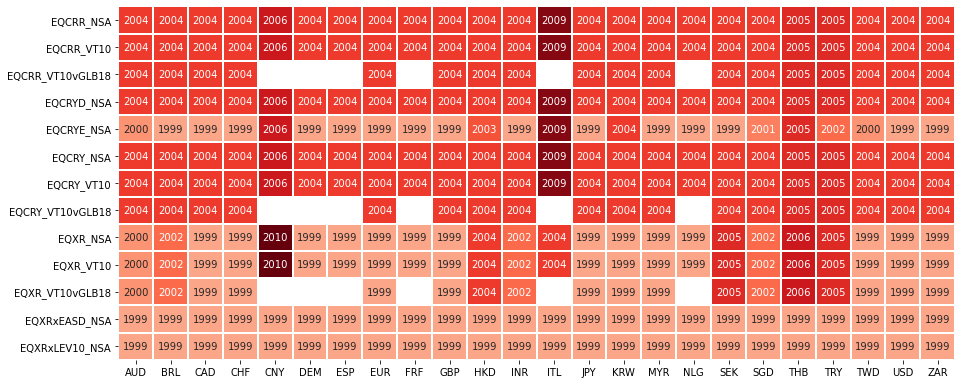

In [22]:
check_availability(dfd, xcats=xcats, cids=cids_exp)

## Distributions and timelines

### Vol and leverage

#### Volatility

Missing cross sections:  set()


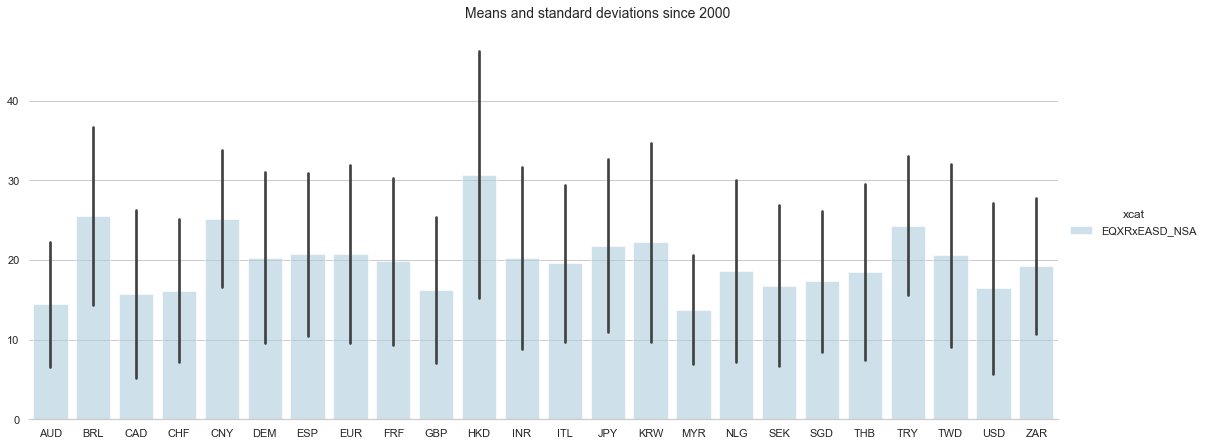

In [24]:
bars_sds(dfd, xcats=['EQXRxEASD_NSA'], cids=cids_exp)

Missing cross sections:  {'NZD', 'NOK'}


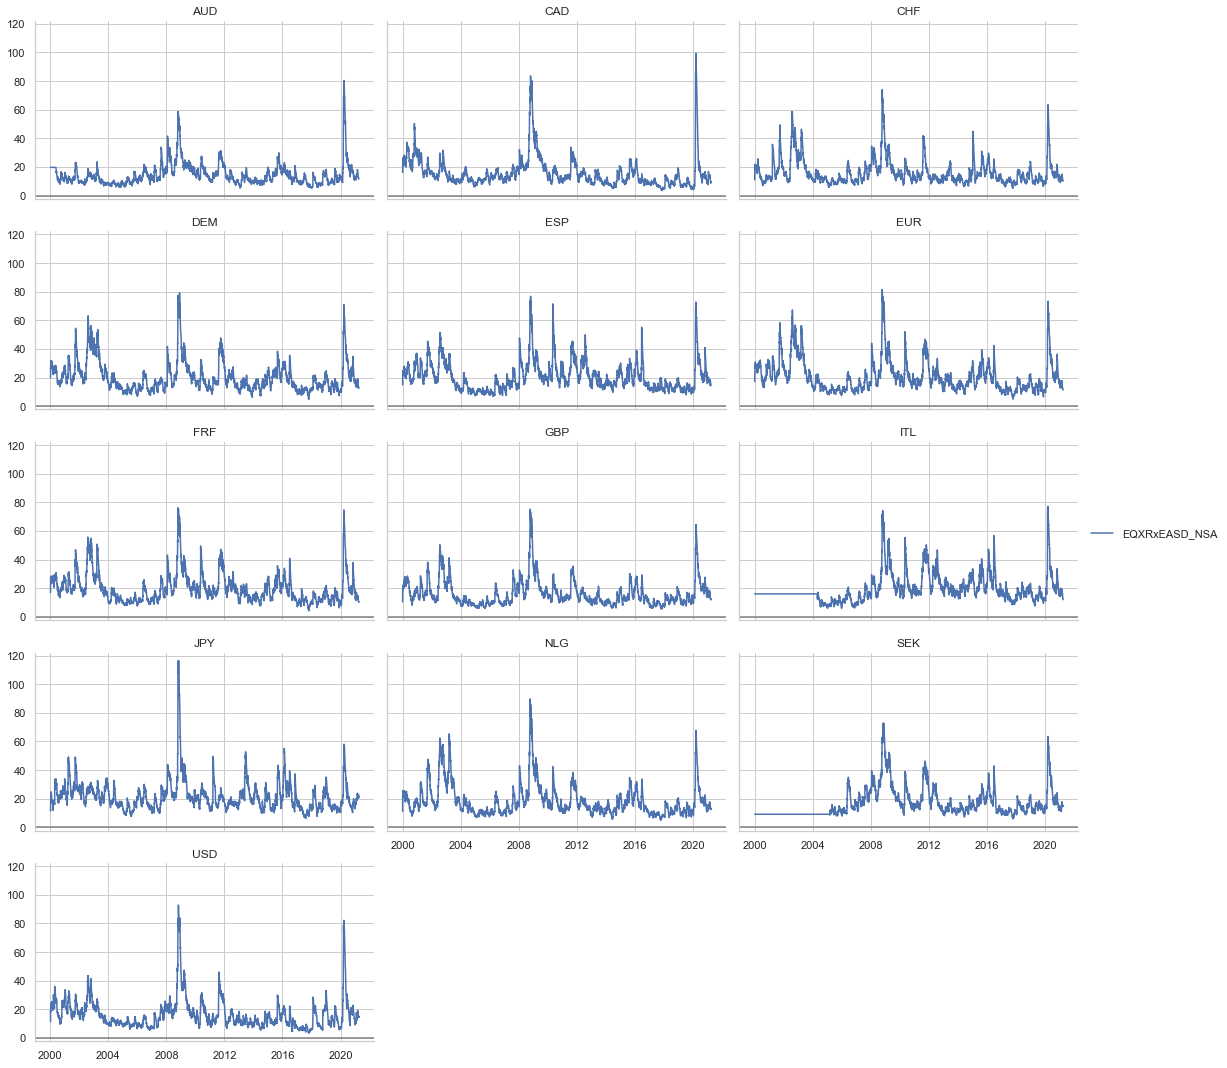

In [25]:
timeline_grid(dfd, xcats=['EQXRxEASD_NSA'], cids=cids_dm, same_y=True)

Missing cross sections:  {'PEN', 'PHP', 'RUB', 'MXN', 'IDR', 'RON', 'ILS', 'COP', 'ARS', 'HUF', 'PLN', 'CLP'}


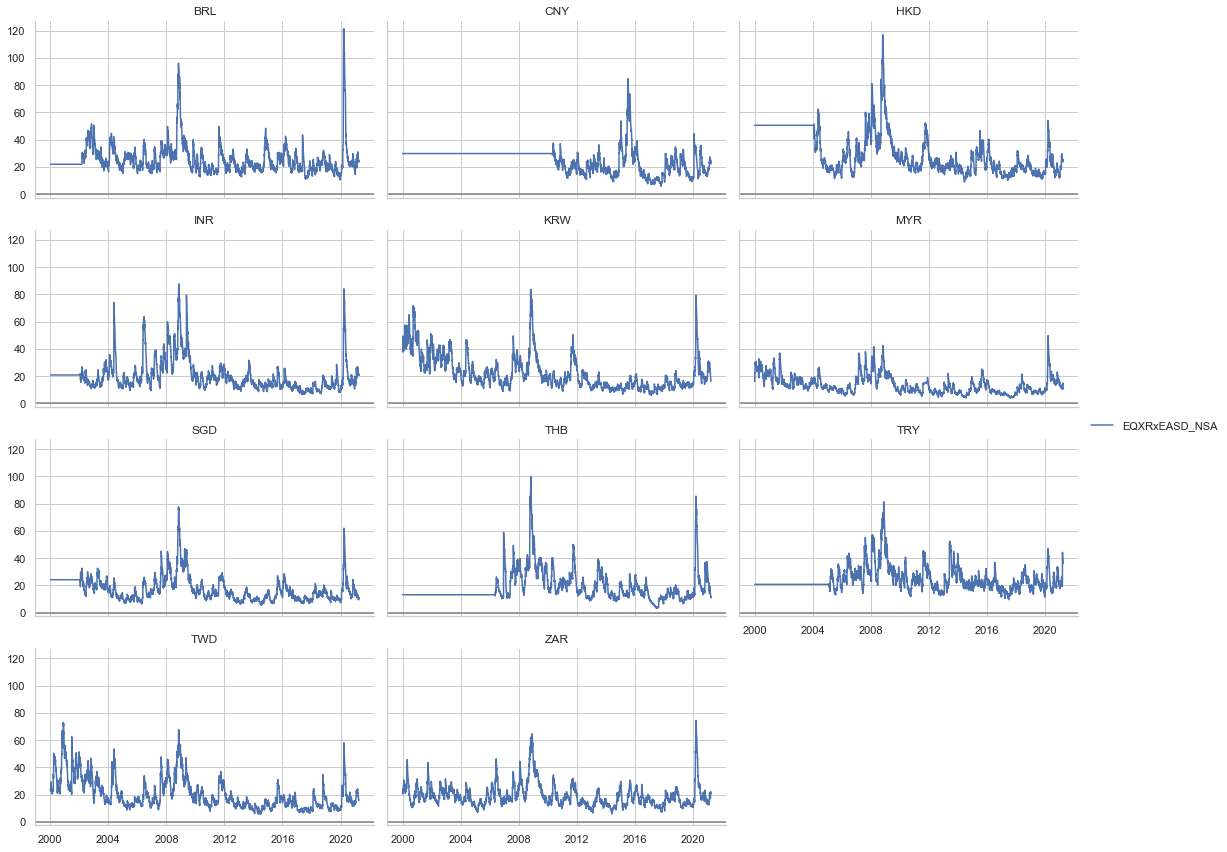

In [26]:
timeline_grid(dfd, xcats=['EQXRxEASD_NSA'], cids=cids_em, same_y=True)

#### Leverage

Missing cross sections:  set()


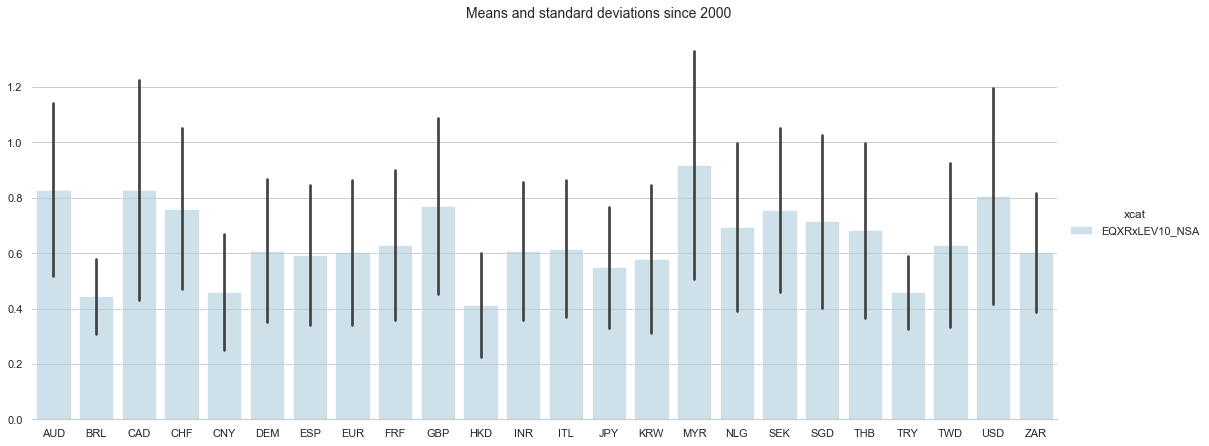

In [27]:
bars_sds(dfd, xcats=['EQXRxLEV10_NSA'], cids=cids_exp)

Missing cross sections:  {'NZD', 'NOK'}


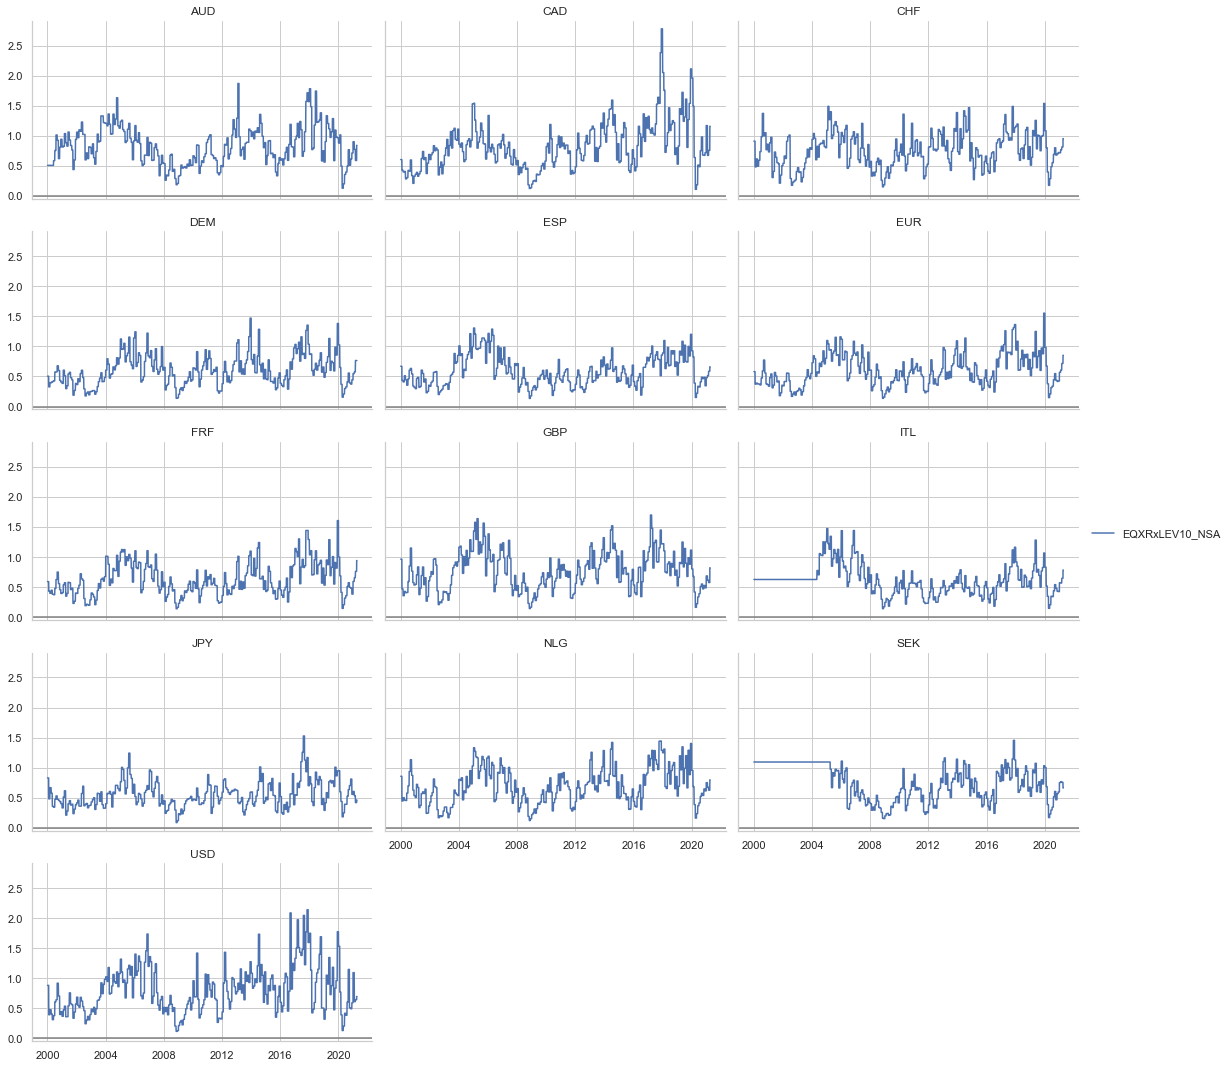

In [28]:
timeline_grid(dfd, xcats=['EQXRxLEV10_NSA'], cids=cids_dm, same_y=True)

Missing cross sections:  {'PEN', 'PHP', 'RUB', 'MXN', 'IDR', 'RON', 'ILS', 'COP', 'ARS', 'HUF', 'PLN', 'CLP'}


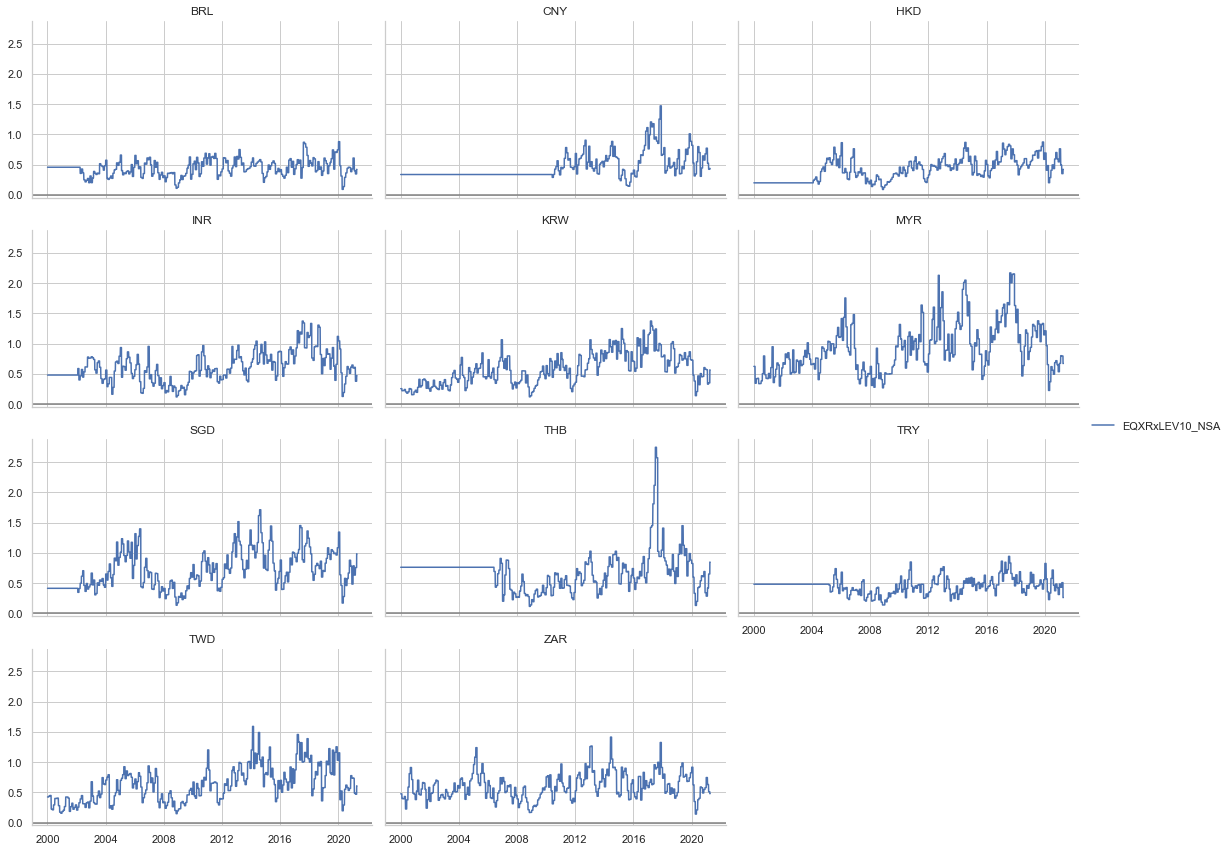

In [29]:
timeline_grid(dfd, xcats=['EQXRxLEV10_NSA'], cids=cids_em, same_y=True)

### Returns

#### Unlevered and vol-targted returns

Missing cross sections:  set()


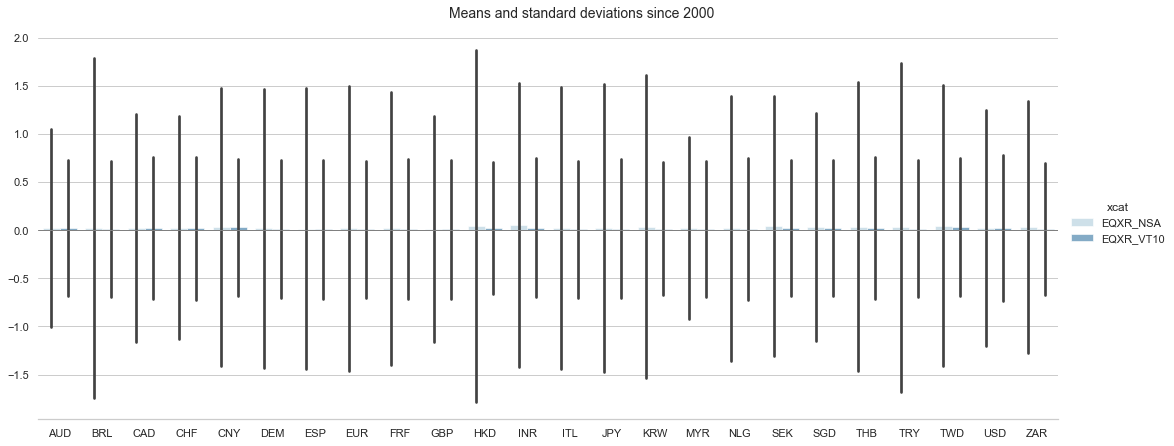

In [31]:
bars_sds(dfd, xcats=['EQXR_NSA', 'EQXR_VT10'], cids=cids_exp)

Missing cross sections:  {'NZD', 'NOK'}


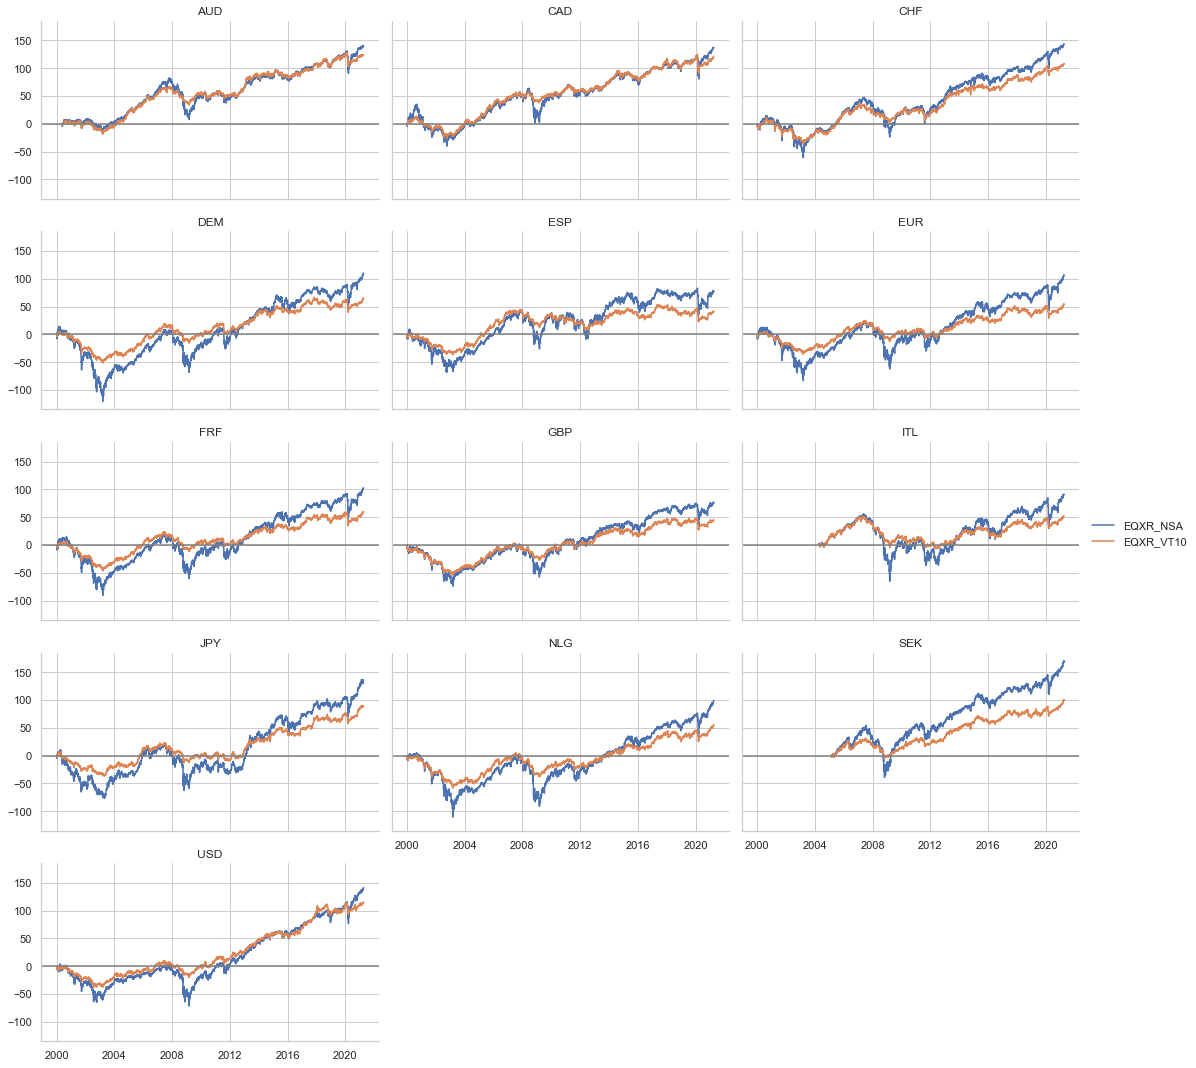

In [33]:
timeline_grid(dfd, xcats=['EQXR_NSA', 'EQXR_VT10'], cids=cids_dm, same_y=True, cumsum=True)

Missing cross sections:  {'PEN', 'PHP', 'RUB', 'MXN', 'IDR', 'RON', 'ILS', 'COP', 'ARS', 'HUF', 'PLN', 'CLP'}


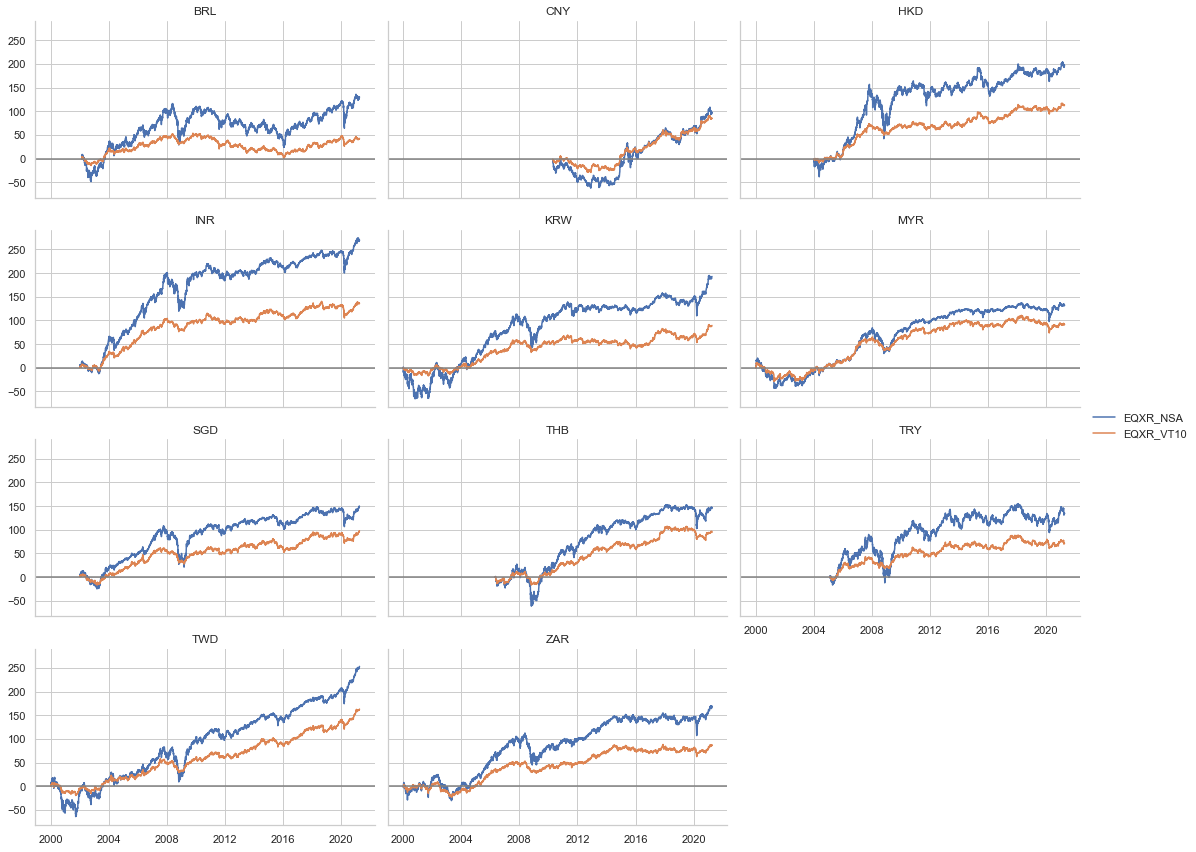

In [34]:
timeline_grid(dfd, xcats=['EQXR_NSA', 'EQXR_VT10'], cids=cids_em, same_y=True, cumsum=True)

#### Relative vol-targetd returns

Missing cross sections:  set()


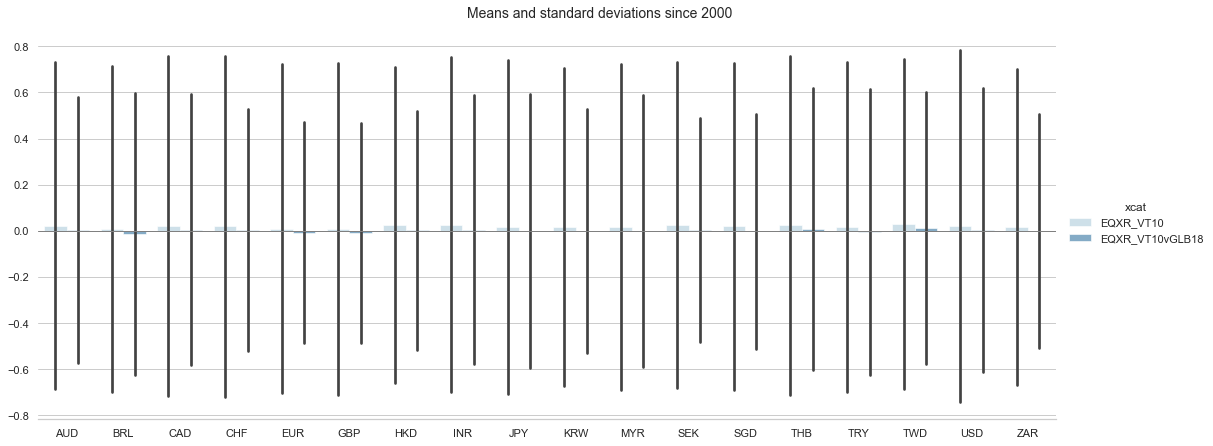

In [42]:
bars_sds(dfd, xcats=['EQXR_VT10', 'EQXR_VT10vGLB18'], cids=cids_rel)

Missing cross sections:  set()


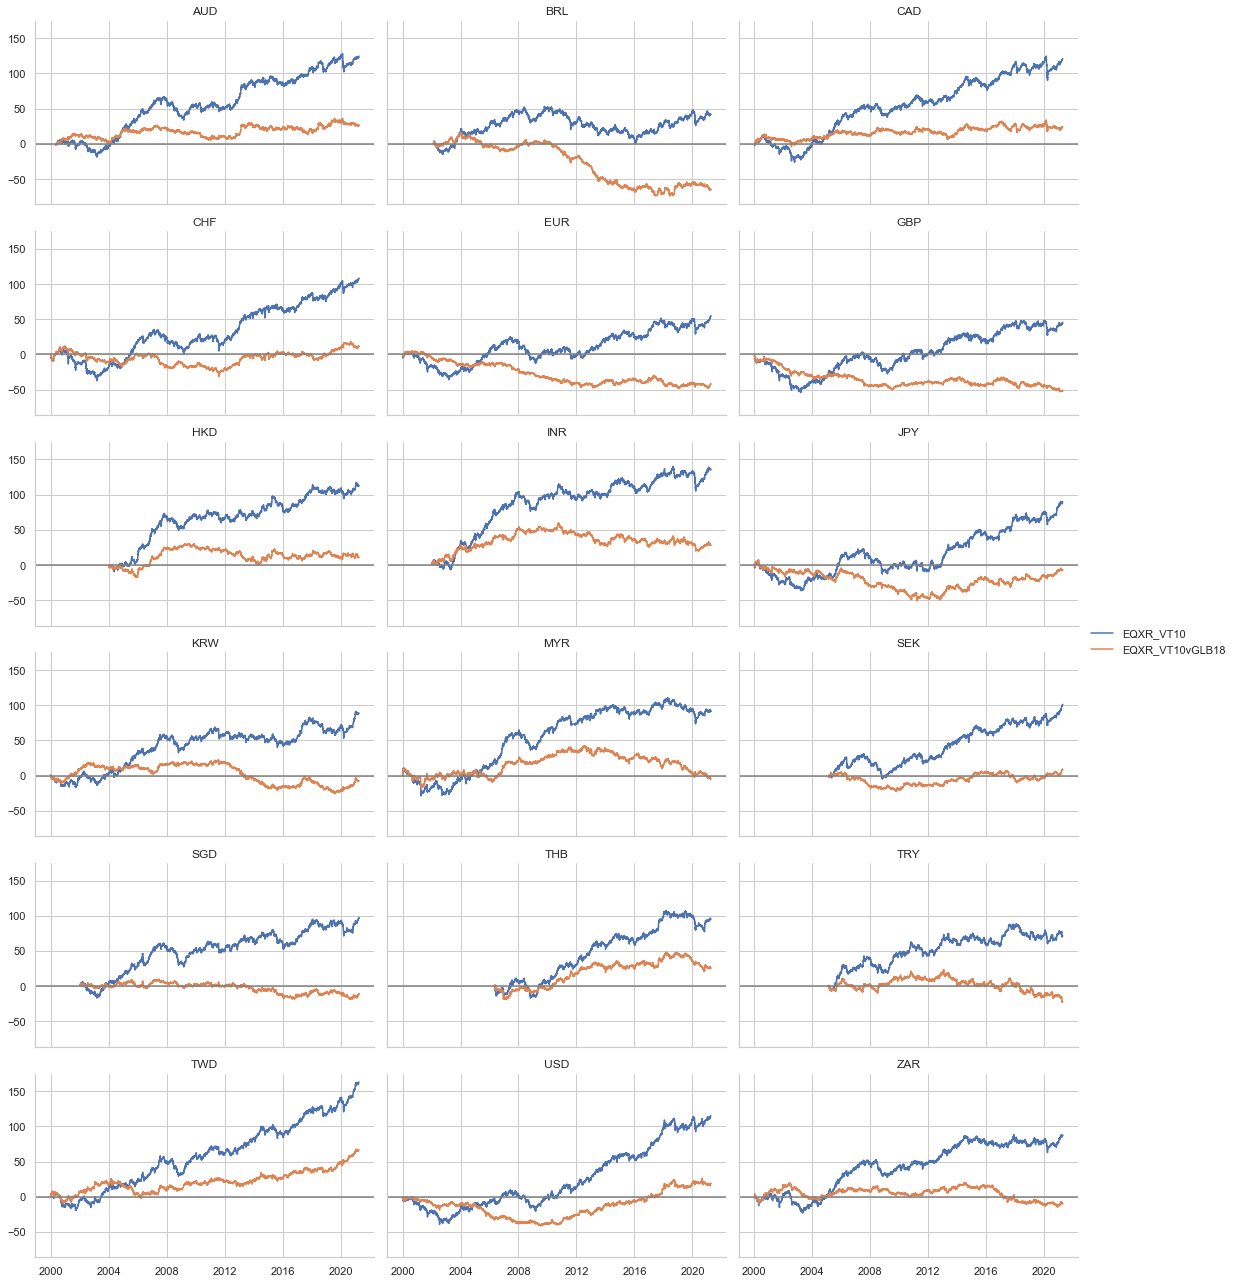

In [43]:
timeline_grid(dfd, xcats=['EQXR_VT10', 'EQXR_VT10vGLB18'], cids=cids_rel, same_y=True, cumsum=True)

### Carry

#### Dividend/ earnings carry

Missing cross sections:  set()


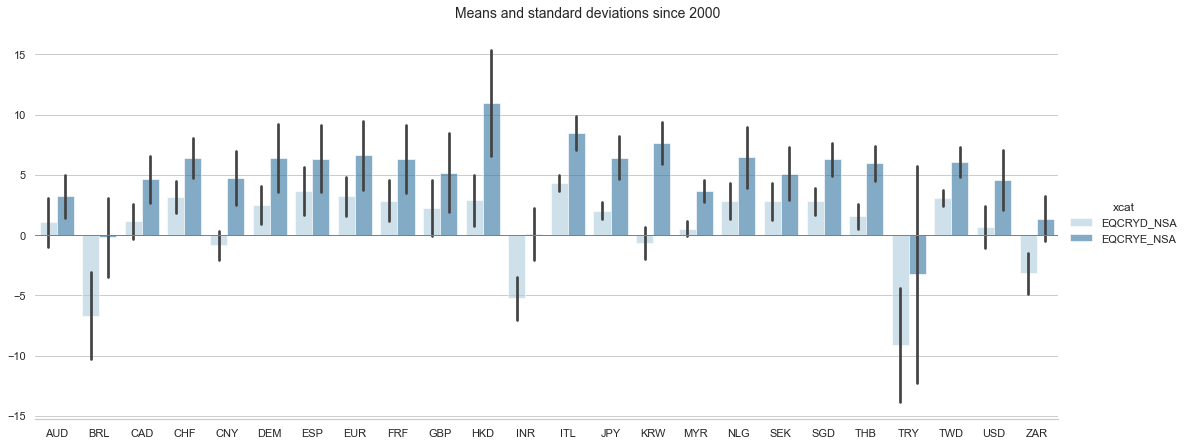

In [44]:
bars_sds(dfd, xcats=['EQCRYD_NSA', 'EQCRYE_NSA'], cids=cids_exp)

Missing cross sections:  {'NZD', 'NOK'}


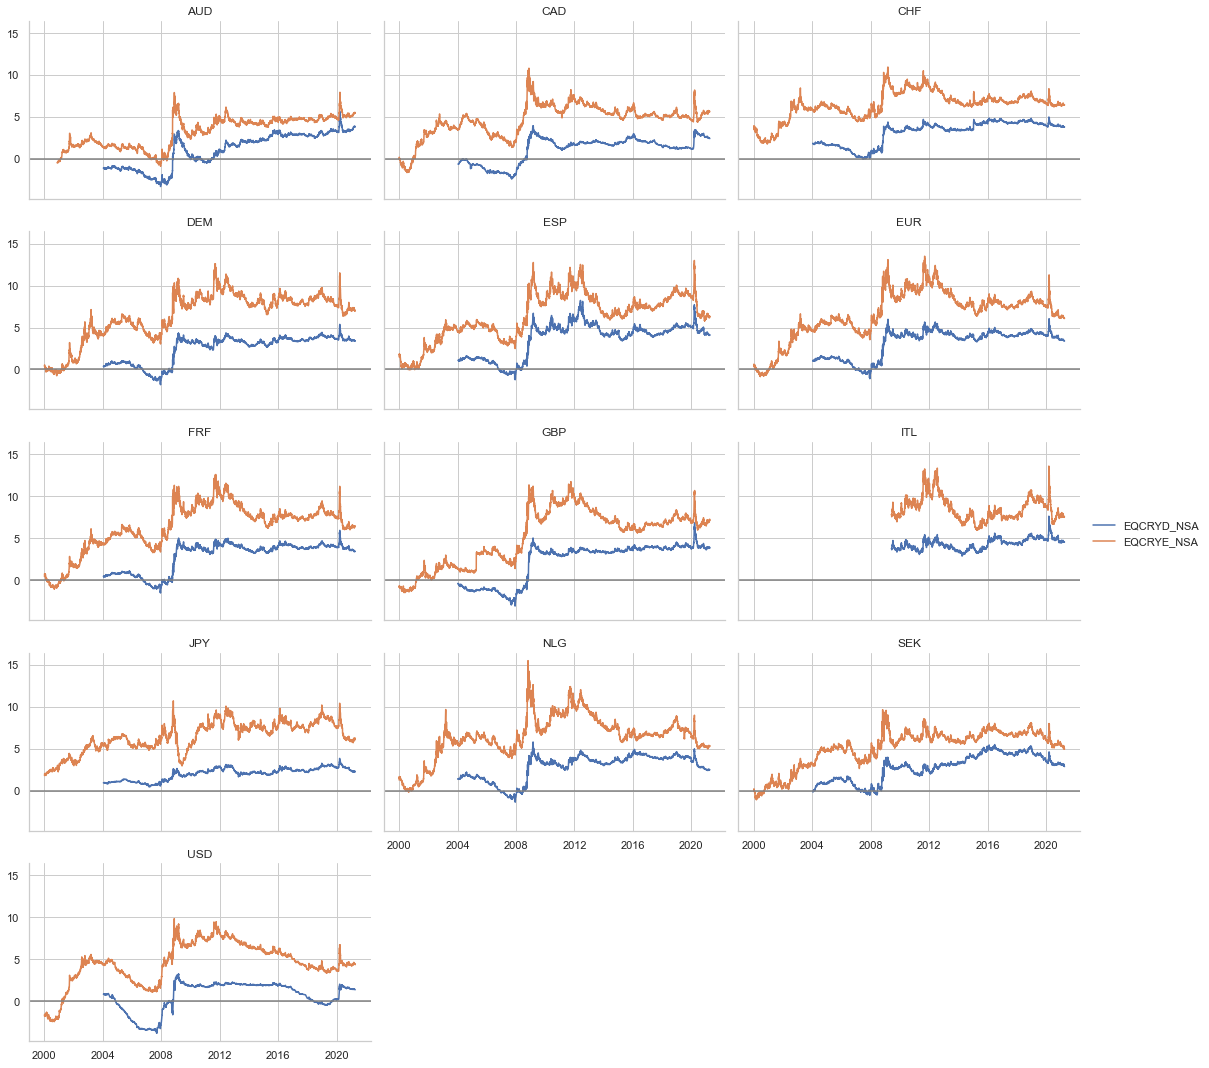

In [45]:
timeline_grid(dfd, xcats=['EQCRYD_NSA', 'EQCRYE_NSA'], cids=cids_dm, same_y=True)

Missing cross sections:  {'PEN', 'PHP', 'RUB', 'MXN', 'IDR', 'RON', 'ILS', 'COP', 'ARS', 'HUF', 'PLN', 'CLP'}


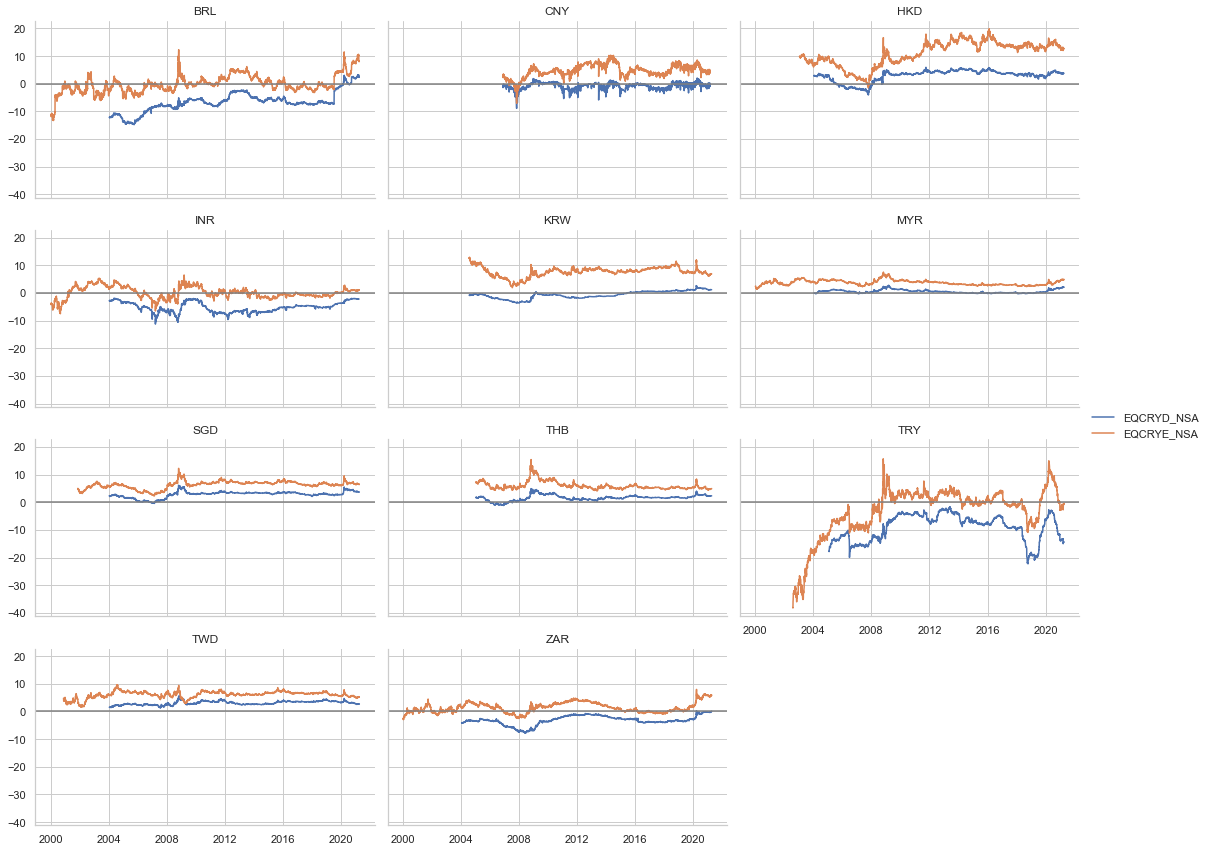

In [46]:
timeline_grid(dfd, xcats=['EQCRYD_NSA', 'EQCRYE_NSA'], cids=cids_em, same_y=True)

#### Nominal/ real carry

Missing cross sections:  set()


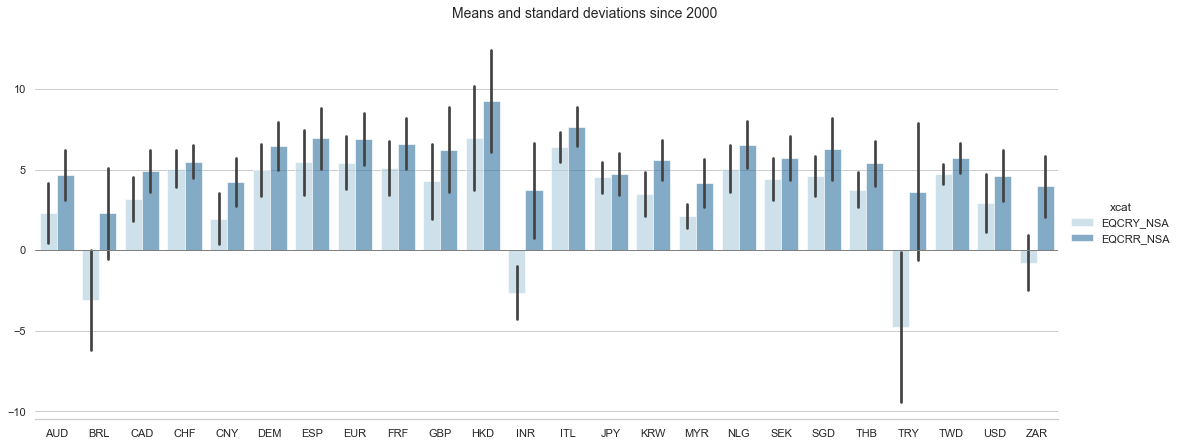

In [47]:
bars_sds(dfd, xcats=['EQCRY_NSA', 'EQCRR_NSA'], cids=cids_exp)

Missing cross sections:  {'NZD', 'NOK'}


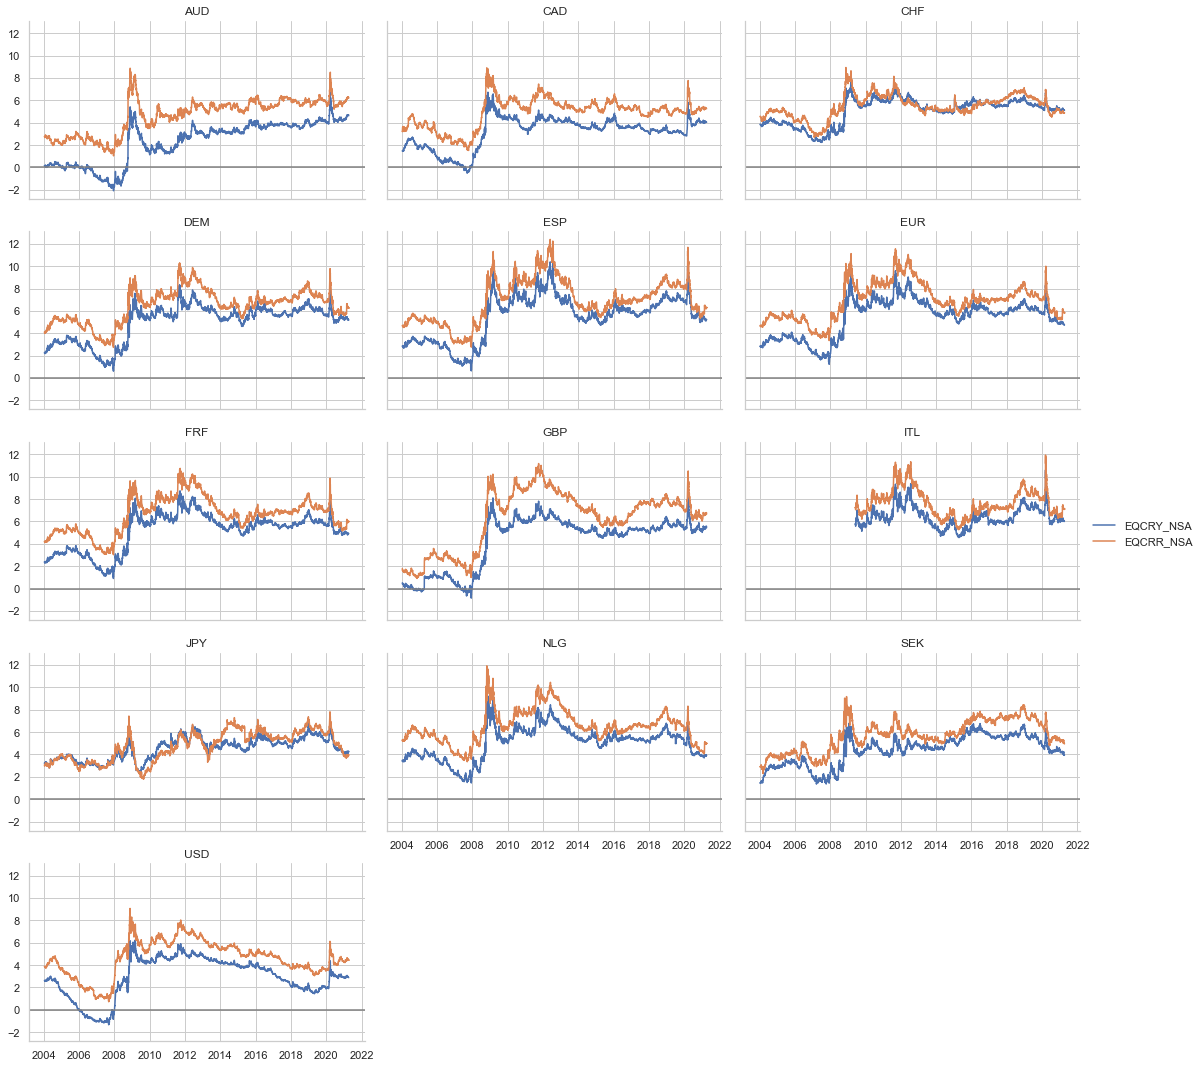

In [48]:
timeline_grid(dfd, xcats=['EQCRY_NSA', 'EQCRR_NSA'], cids=cids_dm, same_y=True)

Missing cross sections:  {'PEN', 'PHP', 'RUB', 'MXN', 'IDR', 'RON', 'ILS', 'COP', 'ARS', 'HUF', 'PLN', 'CLP'}


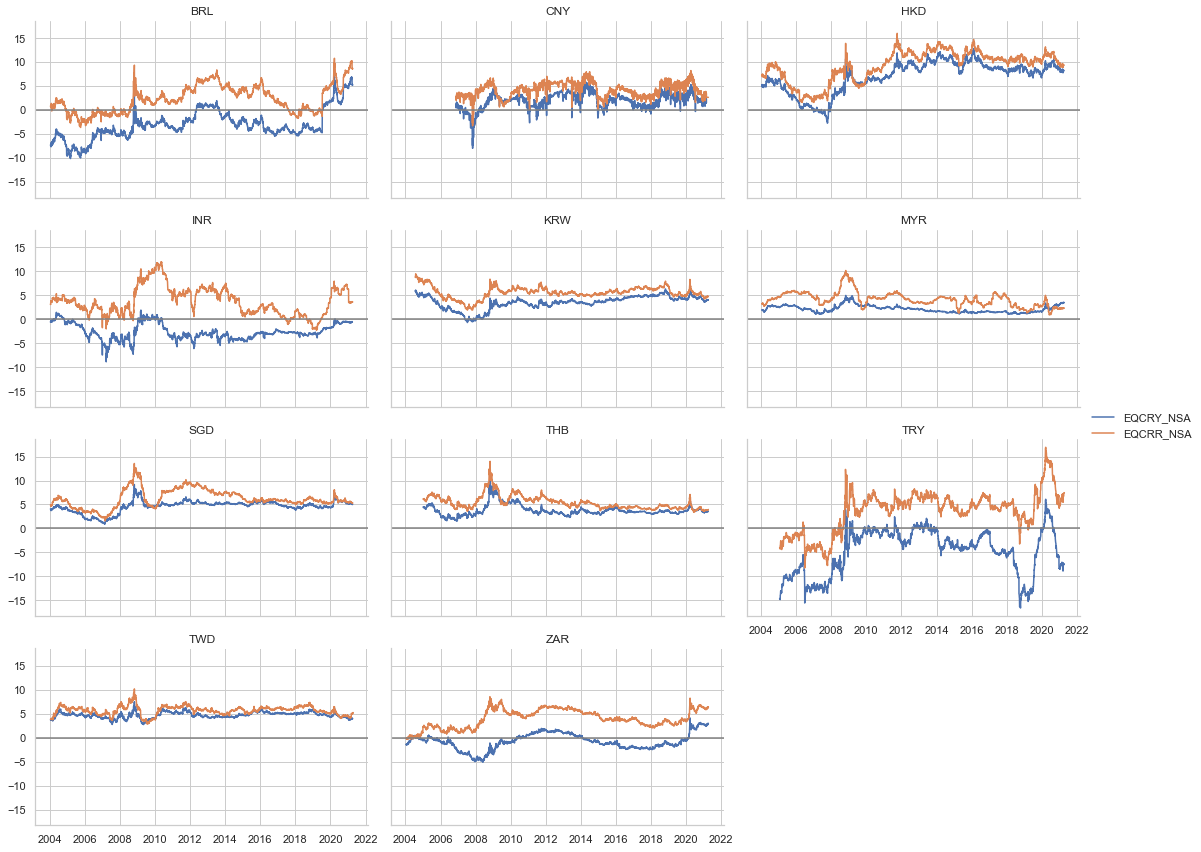

In [49]:
timeline_grid(dfd, xcats=['EQCRY_NSA', 'EQCRR_NSA'], cids=cids_em, same_y=True)

#### Relative/vol-targeted real carry

Missing cross sections:  set()


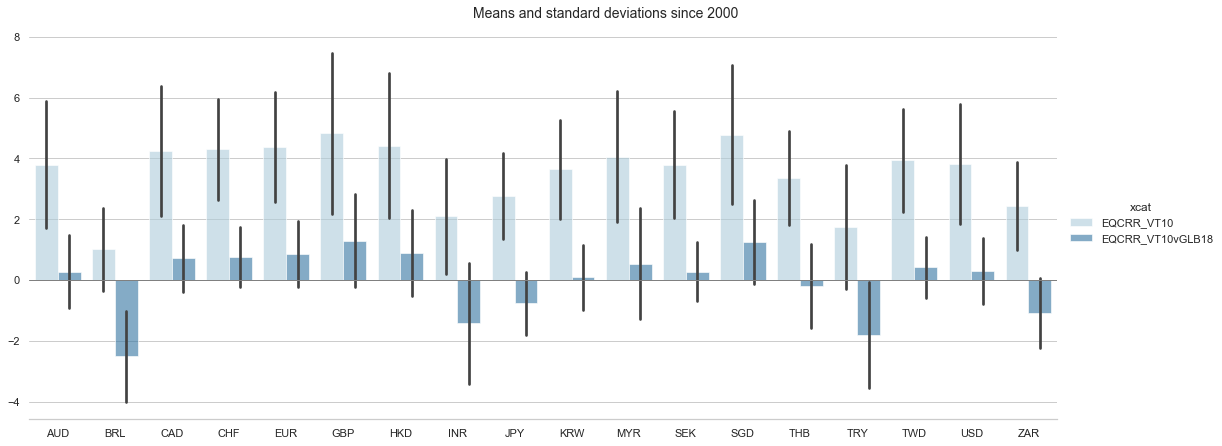

In [53]:
bars_sds(dfd, xcats=['EQCRR_VT10', 'EQCRR_VT10vGLB18'], cids=cids_rel)

Missing cross sections:  set()


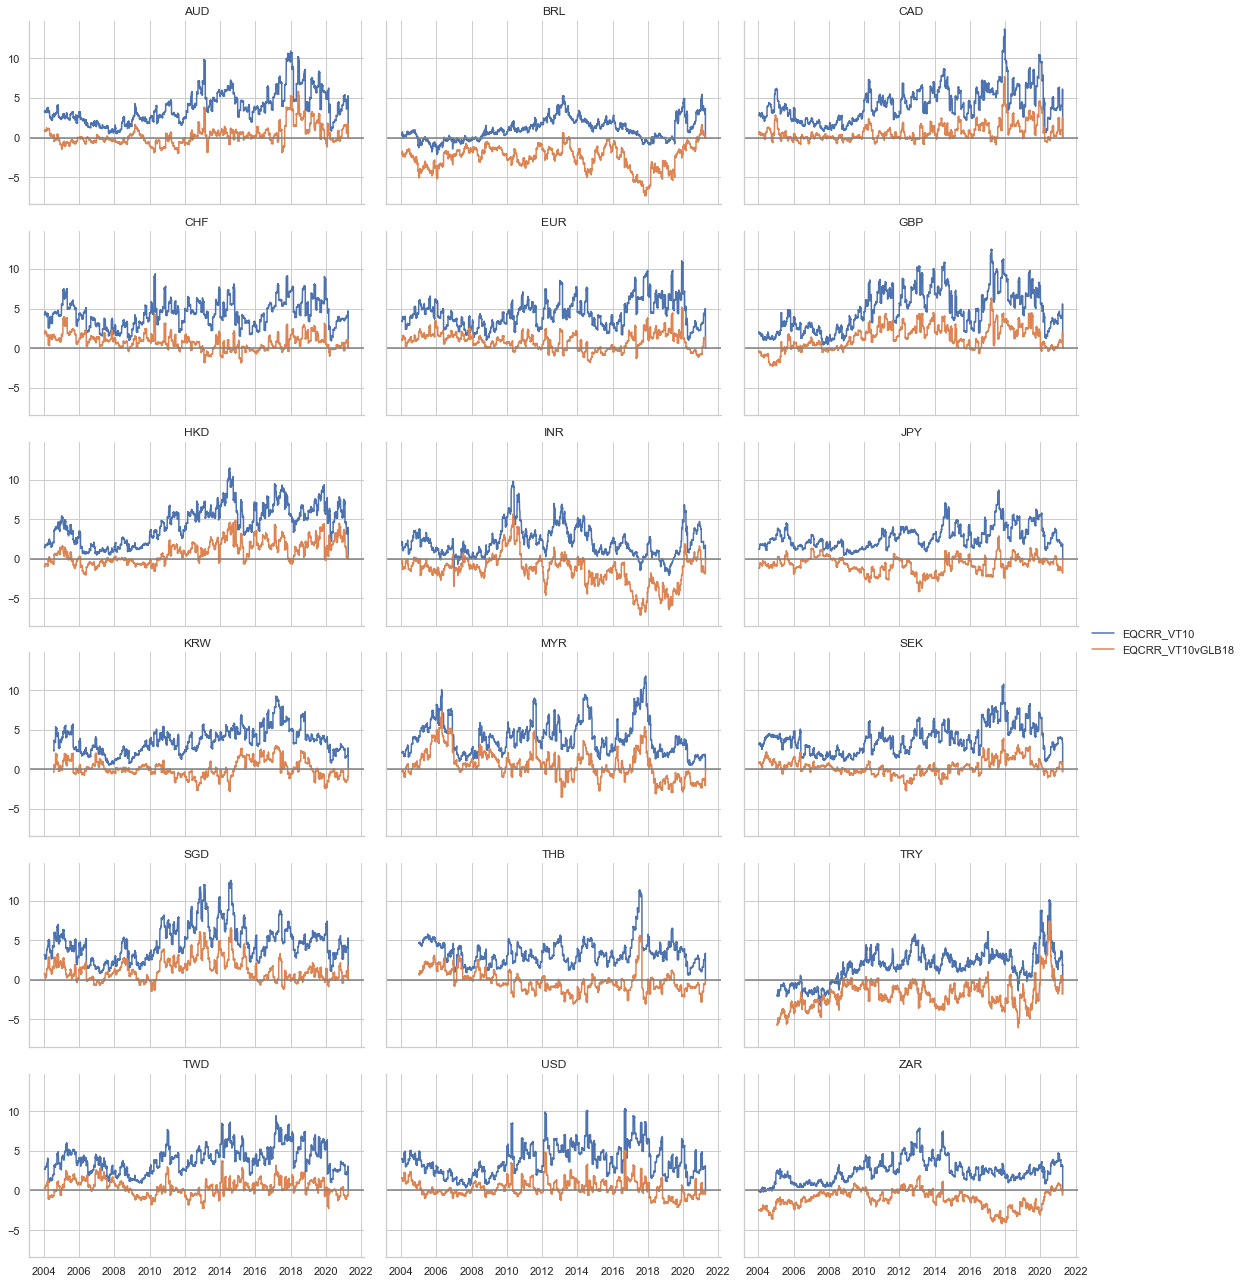

In [52]:
timeline_grid(dfd, xcats=['EQCRR_VT10', 'EQCRR_VT10vGLB18'], cids=cids_rel, same_y=True)